# Data Analysis
This notebook is used to analyze the data collected from live runs. It includes various visualizations and statistical analyses to understand the performance of the runner

## TOC:

## Load the Dataset and Perform any Preprocessing

In [1]:
from utilis.helper import extract_global_json, extract_json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [68]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from scipy.signal import savgol_filter
# add categorical weather conditions
def add_weather_conditions(df, flat):
    # Create categorical weather conditions based on continuous variables
    df['temp_category'] = pd.cut([flat['temp']] * len(df), 
                                  bins=[0, 15, 25, 35], 
                                  labels=['Cold', 'Moderate', 'Hot'])
    
    df['humidity_category'] = pd.cut([flat['humidity']] * len(df), 
                                      bins=[0, 40, 70, 100], 
                                      labels=['Low', 'Medium', 'High'])

    df["dew_category"] = pd.cut([flat['dew']] * len(df), 
                                  bins=[0, 5, 10, 15, 20], 
                                  labels=['Low', 'Medium', 'High', 'Very High'])
    df["uvindex_category"] = pd.cut([flat['uvindex']] * len(df), 
                                      bins=[-1, 3, 6, 9, 12], 
                                      labels=['Low', 'Moderate', 'High', 'Very High'])

    # Create time-based categories
    df['time_category'] = pd.cut(df['time_datetime'].dt.hour, 
                                bins=[0, 6, 12, 18, 24], 
                                labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    return df
# =========
# Load all series
# =========
output_folder = extract_global_json('output_folder')
dataframes = []

# loop through each dataset
for folder_name in os.listdir(output_folder):
    csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
    json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")
    # get the csv_file into a DataFrame
    df = pd.read_csv(csv_file_path, parse_dates=["time_datetime"])
    overall_data = extract_json(json_file_path)

    df["series_id"] = folder_name  # Identify which series

    # Flatten weather dict if present
    flat = overall_data.copy()
    if "weather" in flat and isinstance(flat["weather"], dict):
        for k, v in flat["weather"].items():
            flat[f"{k}"] = v
        del flat["weather"]

    # add categorical weather conditions
    df = add_weather_conditions(df, flat)

    dataframes.append(df)

data = pd.concat(dataframes).sort_values(["series_id", "time_datetime"])

# =========
# Perform some basic preprocessing
# =========

# Remove unnecessary columns
data = data.drop(columns=[
    "moving", 
    "is_original", 
    "pace_efficiency" 
    # "smooth_pace_efficiency", 
    # "diff_pace_efficiency"
    ])

data["smooth_pace_efficiency"] = data.groupby("series_id")["smooth_pace_efficiency"].bfill()
data["diff_pace_efficiency"] = data.groupby("series_id")["diff_pace_efficiency"].fillna(0)
data["relative_winddir_degree"] = data.groupby("series_id")["relative_winddir_degree"].bfill()
data["headwind_mps"] = data.groupby("series_id")["headwind_mps"].bfill()
data["crosswind_mps"] = data.groupby("series_id")["crosswind_mps"].bfill()
data["stride_length_m"] = data.groupby("series_id")["stride_length_m"].bfill()
data["smooth_headwind_mps"] = data.groupby("series_id")["smooth_headwind_mps"].bfill()
data["smooth_crosswind_mps"] = data.groupby("series_id")["smooth_crosswind_mps"].bfill()


# =========
# Encode series_id
# =========
# Define ordinal mappings with meaningful order
ordinal_mappings = {
    'temp_category': ['Cold', 'Moderate', 'Hot'],
    'humidity_category': ['Low', 'Medium', 'High'],
    'dew_category': ['Low', 'Medium', 'High', 'Very High'],
    "uvindex_category": ['Low', 'Moderate', 'High', 'Very High'],
}

for col, categories in ordinal_mappings.items():
    # if "category" in col and col in ordinal_mappings:
    encoder = OrdinalEncoder(categories=[categories]) 
    data[f"{col}_enc"] = encoder.fit_transform(data[[col]])

# Add date features (optional)
data["month"] = data["time_datetime"].dt.month
data["dayofweek"] = data["time_datetime"].dt.dayofweek
data["time_s"] = df.groupby("series_id")["time_datetime"].transform(lambda x: (x - x.iloc[0]).dt.total_seconds())

# Cumulative Elevtion Gain
data["cumulative_elevation_gain_m"] = data.groupby("series_id")["diff_altitude_mps"].transform(lambda x: x.clip(lower=0).cumsum()).fillna(0)


# Different smoothing techniques
# window = 10
# # Simple Moving Average
# data["smooth_altitude_m"] = data.groupby("series_id")["altitude_m"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_heartrate_bps"] = data.groupby("series_id")["heartrate_bps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_velocity_mps"] = data.groupby("series_id")["velocity_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_cadence_rpm"] = data.groupby("series_id")["cadence_rpm"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_grade_percent"] = data.groupby("series_id")["grade_percent"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_headwind_mps"] = data.groupby("series_id")["headwind_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
# data["smooth_crosswind_mps"] = data.groupby("series_id")["crosswind_mps"].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

# # Savitzky-Golay Filter
# data["smooth_altitude_m"] = data.groupby("series_id")["altitude_m"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_heartrate_bps"] = data.groupby("series_id")["heartrate_bps"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_velocity_mps"] = data.groupby("series_id")["velocity_mps"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_cadence_rpm"] = data.groupby("series_id")["cadence_rpm"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_grade_percent"] = data.groupby("series_id")["grade_percent"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_headwind_mps"] = data.groupby("series_id")["headwind_mps"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))
# data["smooth_crosswind_mps"] = data.groupby("series_id")["crosswind_mps"].transform(lambda x: savgol_filter(x, window_length=window, polyorder=2))

data["diff_velocity_mps2"] = data.groupby("series_id")["smooth_velocity_mps"].transform(lambda x: x.diff()).fillna(0)
data["diff_heartrate_bps2"] = data.groupby("series_id")["smooth_heartrate_bps"].transform(lambda x: x.diff()).fillna(0)
data["diff_altitude_mps"] = data.groupby("series_id")["smooth_altitude_m"].transform(lambda x: x.diff()).fillna(0)
# Add lag on velocity
lags = [5, 10, 15, 20]
for lag in lags:
    # data[f"smooth_velocity_mps_lag_{lag}"] = data.groupby("series_id")["smooth_velocity_mps"].shift(lag)
    data[f"smooth_velocity_mps_lag_{lag}"] = data.groupby("series_id")["smooth_velocity_mps"].shift(lag).bfill()

# Add lag on heart rate
for lag in lags:
    # data[f"smooth_heartrate_bps_lag_{lag}"] = data.groupby("series_id")["smooth_heartrate_bps"].shift(lag)
    data[f"smooth_heartrate_bps_lag_{lag}"] = data.groupby("series_id")["smooth_heartrate_bps"].shift(lag).bfill()

C:\Users\katzr\AppData\Local\Temp\ipykernel_4492\579812783.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file_path, parse_dates=["time_datetime"])
C:\Users\katzr\AppData\Local\Temp\ipykernel_4492\579812783.py:71: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  data["diff_pace_efficiency"] = data.groupby("series_id")["diff_pace_efficiency"].fillna(0)


In [69]:
# show all columns
pd.set_option("display.max_columns", None)
# data[data["distance_m"] == 0.0]
# data[data.index==0]
# print(data[data["smooth_pace_efficiency"].isna()])

## Try running time series cross-validation

In [72]:
from sklearn.model_selection import GroupShuffleSplit
# initialize value name and features
features=[
          # "time_s",
          "distance_m", 
          "smooth_heartrate_bps",
          "smooth_heartrate_bps_lag_5",
          # "smooth_heartrate_bps_lag_10",
          # "smooth_heartrate_bps_lag_15",
          "smooth_heartrate_bps_lag_20",
          "smooth_velocity_mps",
          "smooth_velocity_mps_lag_5",
          # "smooth_velocity_mps_lag_10",
          # "smooth_velocity_mps_lag_15",
          "smooth_velocity_mps_lag_20",
        #   "stride_length_m", 
          "smooth_pace_efficiency",
          "diff_pace_efficiency",
          "smooth_altitude_m", 
          "diff_altitude_mps", 
          "smooth_headwind_mps", 
          "smooth_crosswind_mps", 
          "smooth_grade_percent",
          "temp_category_enc",
          "dew_category_enc",
          "cumulative_elevation_gain_m",
          "humidity_category_enc",
          "uvindex_category_enc",
        #   "day_category",
        #   "series_id_enc",
        #   "temp",
        #   "hum",
        #   "month",
        #   "dayofweek"
          ]
# value = "diff_velocity_mps2"
value = "diff_heartrate_bps2"
# value = "smooth_cadence_rps"

# # Drop rows with NaNs from lagging
# data = data.dropna()

# data["series_id_enc"] = encoder.fit_transform(data[["series_id"]])

# =========
# Define features & target
# =========
X = data[features]
y = data[value]

# =========
# Train/test split (time order preserved)
# =========
# use stratified split to ensure series_id distribution
# Split by series_id to avoid data leakage 
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data['series_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Training set size: {X_train.shape[0]}")
print(f"Training series_id: {data.iloc[train_idx]['series_id'].unique()}\n")
print(f"Test set size: {X_test.shape[0]}")
print(f"Test series_id: {data.iloc[test_idx]['series_id'].unique()}\n")


Training set size: 24038
Training series_id: ['2025-07-22_19-40' '2025-07-25_19-53' '2025-07-27_10-27'
 '2025-07-29_20-03' '2025-07-31_20-07' '2025-08-02_18-02'
 '2025-08-04_20-02' '2025-08-06_20-14' '2025-08-11_20-25']

Test set size: 10532
Test series_id: ['2025-07-05_12-32' '2025-08-06_20-43' '2025-08-08_18-48']



### Regression Models

Model Chosen: elastic
Starting hyperparameter tuning...

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best parameters: {'model__alpha': 0.01, 'model__fit_intercept': False, 'model__l1_ratio': 0.01, 'model__max_iter': 1000, 'model__selection': 'cyclic', 'poly__include_bias': True, 'poly__interaction_only': True}
Best CV score: 0.5906

============ Train Dataset Evaluation ============
R² score for Train Dataset: 0.6404
MSE for Train Dataset: 0.0000
MAE for Train Dataset: 0.0023

============ Test Dataset Evaluation ============
R² score for Test Dataset: 0.5197
MSE for Test Dataset: 0.0000
MAE for Test Dataset: 0.0030

============ Feature Importance ============


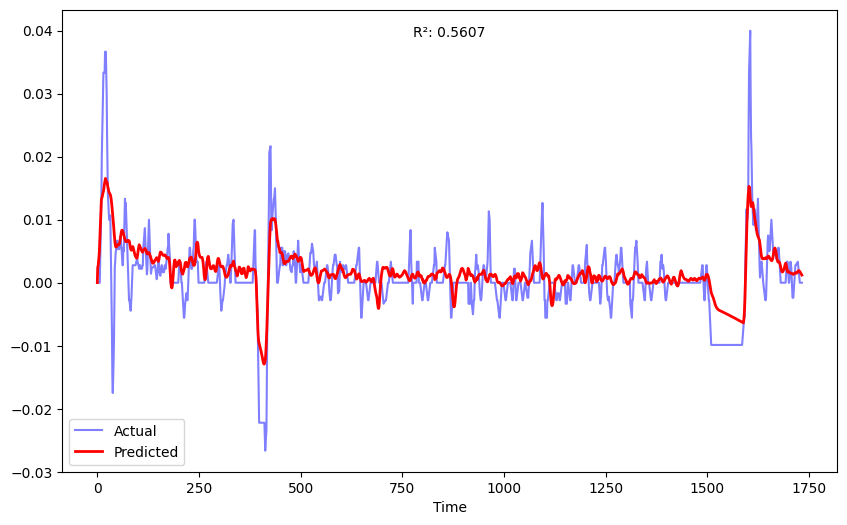

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge
from sklearn.linear_model import HuberRegressor as HuberReg
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np

class SpikeHuberRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, delta=1.0, spike_thresh=0.5, spike_weight=3.0, warm_start=True):
        self.delta = delta
        self.spike_thresh = spike_thresh
        self.spike_weight = spike_weight
        self.warm_start = warm_start
        self._last_params = None  # For warm start

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape

        # Add bias column
        X_bias = np.hstack([np.ones((n_samples, 1)), X])

        # ===== Step 1: Closed-form OLS init =====
        try:
            init_params = np.linalg.lstsq(X_bias, y, rcond=None)[0]
        except np.linalg.LinAlgError:
            init_params = np.zeros(n_features + 1)

        # Warm start reuse
        if self.warm_start and self._last_params is not None:
            init_params = self._last_params

        delta = self.delta
        spike_thresh = self.spike_thresh
        spike_weight = self.spike_weight

        spike_mask = np.abs(y) > spike_thresh
        weights = np.where(spike_mask, spike_weight, 1.0)

        # ===== Loss function =====
        def loss_fn(params):
            y_pred = X_bias @ params
            err = y - y_pred
            mask_quad = np.abs(err) <= delta
            huber_part = np.where(
                mask_quad,
                0.5 * err**2,
                delta * (np.abs(err) - 0.5 * delta)
            )
            return np.mean(weights * huber_part)

        # ===== Analytical gradient =====
        def grad_fn(params):
            y_pred = X_bias @ params
            err = y - y_pred
            mask_quad = np.abs(err) <= delta

            # Derivative of Huber wrt y_pred
            grad_pred = np.where(
                mask_quad,
                -err,                             # derivative of 0.5*err² wrt y_pred
                -delta * np.sign(err)              # derivative of δ(|err| - δ/2)
            )

            grad_pred *= weights  # spike weights

            # Chain rule: dL/dparams = (1/n) * X_biasᵀ @ grad_pred
            return (X_bias.T @ grad_pred) / n_samples

        # ===== Step 2: Optimize with analytical gradient =====
        result = minimize(
            loss_fn,
            init_params,
            jac=grad_fn,              # Analytical gradient
            method="L-BFGS-B",
            options={"maxiter": 200, "ftol": 1e-8}
        )

        self.bias_ = result.x[0]
        self.coef_ = result.x[1:]
        self._last_params = result.x if self.warm_start else None
        return self

    def predict(self, X):
        return X @ self.coef_ + self.bias_

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class RidgeRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make sklearn Ridge compatible with sklearn Pipeline"""
    def __init__(self, alpha=1.0, fit_intercept=True, solver='auto', max_iter=None, 
                 tol=1e-3, random_state=None, positive=False):
        self.model_ = None
        self.feature_count_ = None
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.solver = solver
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.positive = positive

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        # Create Ridge with all parameters
        self.model_ = Ridge(
            alpha=self.alpha,
            fit_intercept=self.fit_intercept,
            solver=self.solver,
            max_iter=self.max_iter,
            tol=self.tol,
            random_state=self.random_state,
            positive=self.positive
        ).fit(X, y)
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class ElasticRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make sklearn ElasticNet compatible with sklearn Pipeline"""
    def __init__(self, alpha=1.0, l1_ratio=0.5, fit_intercept=True, max_iter=1000, 
                 tol=1e-4, random_state=None, positive=False, selection='cyclic'):
        self.model_ = None
        self.feature_count_ = None
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # ElasticNet specific parameter
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.positive = positive
        self.selection = selection  # 'cyclic' or 'random'

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        # Create ElasticNet with correct parameters
        self.model_ = ElasticNet(
            alpha=self.alpha,
            l1_ratio=self.l1_ratio,
            fit_intercept=self.fit_intercept,
            max_iter=self.max_iter,
            tol=self.tol,
            random_state=self.random_state,
            positive=self.positive,
            selection=self.selection
        ).fit(X, y)
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {
            'alpha': self.alpha,
            'l1_ratio': self.l1_ratio,
            'fit_intercept': self.fit_intercept,
            'max_iter': self.max_iter,
            'tol': self.tol,
            'random_state': self.random_state,
            'positive': self.positive,
            'selection': self.selection
        }

    def set_params(self, **params):
        """Set the parameters of this estimator."""
        for key, value in params.items():
            setattr(self, key, value)
        return self

class LinearRegressor(BaseEstimator, RegressorMixin):
    """Wrapper to make sklearn LinearRegression compatible with sklearn Pipeline"""
    def __init__(self):
        self.model_ = None
        self.feature_count_ = None

    def fit(self, X, y):
        # Store the number of features for consistency check
        self.feature_count_ = X.shape[1]
        
        self.model_ = LinearRegression().fit(X, y)
        return self
    
    def predict(self, X):
        # Check feature count consistency
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class BayesianRidgeRegressor(BaseEstimator, RegressorMixin):
    """Wrapper for sklearn BayesianRidge"""
    def __init__(self, alpha_1=1e-6, alpha_2=1e-6, lambda_1=1e-6, lambda_2=1e-6, fit_intercept=True):
        self.model_ = None
        self.feature_count_ = None
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        self.feature_count_ = X.shape[1]
        self.model_ = BayesianRidge(
            alpha_1=self.alpha_1,
            alpha_2=self.alpha_2,
            lambda_1=self.lambda_1,
            lambda_2=self.lambda_2,
            fit_intercept=self.fit_intercept
        ).fit(X, y)
        return self
    
    def predict(self, X):
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class HuberRegressor(BaseEstimator, RegressorMixin):
    """Wrapper for sklearn HuberRegressor"""
    def __init__(self, epsilon=1.35, alpha=0.0001, max_iter=100):
        self.model_ = None
        self.feature_count_ = None
        self.epsilon = epsilon
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X, y):
        self.feature_count_ = X.shape[1]
        self.model_ = HuberReg(
            epsilon=self.epsilon,
            alpha=self.alpha,
            max_iter=self.max_iter
        ).fit(X, y)
        return self
    
    def predict(self, X):
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

class KernelRidgeRegressor(BaseEstimator, RegressorMixin):
    """Wrapper for sklearn KernelRidge"""
    def __init__(self, alpha=1.0, kernel='linear', gamma=None, degree=3, coef0=1):
        self.model_ = None
        self.feature_count_ = None
        self.alpha = alpha
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0

    def fit(self, X, y):
        self.feature_count_ = X.shape[1]
        self.model_ = KernelRidge(
            alpha=self.alpha,
            kernel=self.kernel,
            gamma=self.gamma,
            degree=self.degree,
            coef0=self.coef0
        ).fit(X, y)
        return self
    
    def predict(self, X):
        if X.shape[1] != self.feature_count_:
            raise ValueError(f"Expected {self.feature_count_} features, got {X.shape[1]}")
        return self.model_.predict(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred), mean_squared_error(y, y_pred), mean_absolute_error(y, y_pred)

    def get_params(self, deep=True):
        return {
            'alpha': self.alpha,
            'kernel': self.kernel,
            'gamma': self.gamma,
            'degree': self.degree,
            'coef0': self.coef0
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
# =========
# Hyperparameter tuning
# =========
model = "custom"
# model = "ridge"
# model = "elastic"
# model = "bayesian_ridge"
# model = "huber"
# model = "kernel_ridge"

print(f"Model Chosen: {model}")
linear_models = {
    "custom" : Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=True)),
        ("model", SpikeHuberRegressor())
    ]),
    "ridge" : Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=True)),
        # ("feature_selection", SelectKBest(f_regression, k=15)),  # Limit total features
        ("model", RidgeRegressor())
    ]),
    "elastic" : Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=True)),
        ("model", ElasticRegressor(alpha=1.0, l1_ratio=0.5))
    ]),
    "bayesian_ridge" : Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=True)),
        ("model", BayesianRidgeRegressor())
    ]),
    "huber" : Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=1, include_bias=True)),
        ("model", HuberRegressor())
    ]),
    "kernel_ridge" : Pipeline([
        ("scaler", StandardScaler()),
        ("model", KernelRidgeRegressor())
    ])
}

param_grids = {
    "custom" : {
        "model__delta": [0.01, 0.05, 0.1],          # Huber transition
        "model__spike_thresh": [0.25, 0.5, 0.7],   # Spike detection threshold
        "model__spike_weight": [0.25, 0.5, 1.0],   # Spike loss multiplier
        "poly__interaction_only": [True, False],
        "poly__include_bias": [True, False]
    },
    "ridge" : {
        'model__alpha': [0.01, 0.1, 1.0, 10.0],
        # 'model__alpha': [1.0],
        # 'model__alpha': [0.0001, 0.001, 0.01, 0.1],
        # 'feature_selection__k': [8, 12, 'all'],
        # 'model__solver': ['auto', 'cholesky', 'lsqr'],
        # 'feature_selection__k': [10, 15, 20],  # Experiment with different numbers
        'model__max_iter': [1000, 2000],
        'model__fit_intercept': [False],
        'poly__interaction_only': [True, False],
        'poly__include_bias': [True, False],
        # 'poly__order': ['C', 'F'],  # Memory layout order
    }, 
    "elastic" : {
        'model__alpha': [0.01, 0.1, 1.0, 10.0],
        'model__l1_ratio': [0.01, 0.1, 0.25, 0.5],  # Mix of L1 and L2 regularization
        'model__fit_intercept': [True, False],
        'model__max_iter': [1000, 2000],
        'model__selection': ['cyclic', 'random'],
        'poly__interaction_only': [True, False],
        'poly__include_bias': [True, False]
    },
    "bayesian_ridge" : {
        'model__alpha_1': [1e-6, 1e-5, 1e-4],
        'model__alpha_2': [1e-6, 1e-5, 1e-4],
        'model__lambda_1': [1e-6, 1e-5, 1e-4],
        'model__lambda_2': [1e-6, 1e-5, 1e-4],
        'model__fit_intercept': [True, False],
        'poly__interaction_only': [True, False],
        'poly__include_bias': [True, False]
    },
    "huber" : {
        'model__epsilon': [1.35, 1.5, 1.75],
        'model__alpha': [0.0001, 0.001, 0.01, 0.1],
        'model__max_iter': [100, 200, 300],
        'poly__interaction_only': [True, False],
        'poly__include_bias': [True, False]
    },
    "kernel_ridge" : {
        'model__alpha': [0.1, 1.0, 10.0],
        'model__kernel': ['polynomial', 'rbf'],
        'model__gamma': [0.01, 0.1, 1.0, 10.0],
        'model__degree': [2, 3],
        'model__coef0': [0.0, 1.0]
    }
}

pipeline = linear_models[model]
param_grid = param_grids[model]

# Use time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=tscv, 
    # scoring='neg_mean_squared_error',
    scoring='r2',
    n_jobs=-1,
    verbose=1  # Add this to see progress
)

print("Starting hyperparameter tuning...\n")
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}\n")

# Use the best estimator for final evaluation
best_pipeline = grid_search.best_estimator_

best_pipeline.fit(X_train, y_train)

# =========
# Evaluate
# =========

print("============ Train Dataset Evaluation ============")
r2_train, mse_train, mae_train = best_pipeline.score(X_train, y_train)
print(f"R² score for Train Dataset: {r2_train:.4f}")
print(f"MSE for Train Dataset: {mse_train:.4f}")
print(f"MAE for Train Dataset: {mae_train:.4f}")

print("\n============ Test Dataset Evaluation ============")
r2_test, mse_test, mae_test = best_pipeline.score(X_test, y_test)
print(f"R² score for Test Dataset: {r2_test:.4f}")
print(f"MSE for Test Dataset: {mse_test:.4f}")
print(f"MAE for Test Dataset: {mae_test:.4f}")

print("\n============ Feature Importance ============")
# Access the model from the pipeline and then get coefficients
model_step = best_pipeline.named_steps["model"]
# Get coefficients and create a list of (feature, coefficient) pairs
if hasattr(model_step, 'coef_'):
    feature_coef_pairs = [(feature, model_step.coef_[features.index(feature)]) for feature in features]

    # Sort by absolute value of coefficient (largest magnitude first)
    feature_coef_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

    # Print sorted features
    for feature, coef in feature_coef_pairs:
        print(f"{feature}: {coef:.4f}")
# print(f"Model coefficients: {model_step.coef_}")


# test date
# test = "2025-07-05_12-32"
# test = "2025-07-22_19-40"
# test = "2025-07-31_20-07"
# test = "2025-08-02_18-02"
# test = "2025-08-06_20-14"
# test = "2025-08-06_20-43"
test = "2025-08-08_18-48"
# plot actual vs predicted
y_pred = best_pipeline.predict(data[data["series_id"] == test][features])
model = best_pipeline.named_steps["model"]
x = "time_s"
# x = "distance_m"
plt.figure(figsize=(10, 6))
plt.plot(data[data["series_id"] == test][x], data[data["series_id"] == test][value], label="Actual", color="blue", alpha=0.5)
plt.plot(data[data["series_id"] == test][x], y_pred, label="Predicted", color="red", linewidth=2)
plt.text(0.5, 0.95, f"R²: {r2_score(data[data['series_id'] == test][value], y_pred):.4f}", ha='center', va='center', transform=plt.gca().transAxes)
plt.xlabel("Time") 
plt.legend()
plt.show()


### Neural Network

In [ ]:
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =========
# Model 1: Simple Feedforward Neural Network
# =========
def create_simple_nn(input_dim):
    model = keras.Sequential([
        # layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        
        # layers.Dense(64, activation='relu'),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        
        # layers.Dense(32, activation='relu'),
        # layers.Dropout(0.2),
        
        # layers.Dense(16, activation='relu'),
        # layers.Dense(1)  # Output layer for regression
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1)
    ])
    # Use a different optimizer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                  loss='huber', # More robust to outliers than MSE
                  metrics=['mae'])
    return model

features=["distance_m", 
          "smooth_heartrate_bps",
          "smooth_velocity_mps",
          "stride_length_m", 
          "smooth_altitude_m", 
          "diff_altitude_mps", 
          "smooth_headwind_mps", 
          "smooth_crosswind_mps", 
          "smooth_grade_percent",
          "cumulative_elevation_gain_m",
          "temp_category_enc",
          "humidity_category_enc",
        #   "pace_efficiency",
        #   "day_category",
        #   "series_id_enc",
        #   "month",
        #   "dayofweek"
          ]


# =========
# Train/Test Split (Group-based to avoid data leakage)
# =========
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data['series_id']))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Further split training into train/validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Scale features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

models = {}
histories = {}

# 1. Simple Neural Network
print("Training Simple Neural Network...")
simple_nn = create_simple_nn(X_train_scaled.shape[1])
simple_nn.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5)

history_simple = simple_nn.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=60,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

models['Simple NN'] = simple_nn
histories['Simple NN'] = history_simple

# =========
# Model Evaluation
# =========
print("\n" + "="*60)
print("NEURAL NETWORK MODEL EVALUATION")
print("="*60)

results = {}

for name, model in models.items():
    if name == 'LSTM':
        # Handle LSTM predictions differently
        continue
    
    # Predictions
    y_train_pred = model.predict(X_train_scaled, verbose=0).flatten()
    y_val_pred = model.predict(X_val_scaled, verbose=0).flatten()
    y_test_pred = model.predict(X_test_scaled, verbose=0).flatten()
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results[name] = {
        'train_r2': train_r2, 'val_r2': val_r2, 'test_r2': test_r2,
        'train_rmse': train_rmse, 'val_rmse': val_rmse, 'test_rmse': test_rmse,
        'predictions': y_test_pred
    }
    
    print(f"\n{name} Results:")
    print(f"  Train R²: {train_r2:.4f}")
    print(f"  Val R²:   {val_r2:.4f}")
    print(f"  Test R²:  {test_r2:.4f}")
    print(f"  Test RMSE: {test_rmse:.6f}")

# =========
# Visualizations
# =========
# Training history plots
fig, axes = plt.subplots(2, len(histories), figsize=(5*len(histories), 10))
if len(histories) == 1:
    axes = axes.reshape(-1, 1)

for i, (name, history) in enumerate(histories.items()):
    # Loss plot
    axes[0, i].plot(history.history['loss'], label='Training Loss')
    axes[0, i].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, i].set_title(f'{name} - Loss')
    axes[0, i].set_xlabel('Epoch')
    axes[0, i].set_ylabel('Loss')
    axes[0, i].legend()
    
    # MAE plot
    axes[1, i].plot(history.history['mae'], label='Training MAE')
    axes[1, i].plot(history.history['val_mae'], label='Validation MAE')
    axes[1, i].set_title(f'{name} - MAE')
    axes[1, i].set_xlabel('Epoch')
    axes[1, i].set_ylabel('MAE')
    axes[1, i].legend()

plt.tight_layout()
plt.show()